### Carregando dados

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [2]:
sns.set_theme(style="ticks", palette="pastel")

In [3]:
transactions = pd.read_csv('data/transactions_train.csv')

In [4]:
articles = pd.read_csv('data/articles.csv')

In [5]:
customers = pd.read_csv('data/customers.csv')

### Utils

Funções para display das imagens

In [6]:
path = 'C:/Users/enyal/Documents/tp_mineracao_dados/images/'

def img_reshape(path):
    img = Image.open(path).convert('RGB')
    img = img.resize((300,300))
    img = np.asarray(img)
    return img

def display_articles(article_ids):
    rows = 4
    cols = 3

    plt.figure(figsize=(2 + 3 * cols, 2 + 4 * rows))

    for i in range(len(article_ids)):
        article_id = ("0" + str(article_ids[i]))[-10:]
        image_url = (f"{path}{article_id[:3]}/{article_id}.jpg")
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')

        try:
            Image.open(image_url)
            image = img_reshape(image_url)
            plt.imshow(image)
        except:
            None

def show_image(article_id):
    article_id = ("0" + str(article_id))[-10:]
    img = img_reshape(f"{path}{article_id[:3]}/{article_id}.jpg")
    plt.imshow(img)
    plt.axis('off')

### Transformações

In [7]:
articles['detail_desc'].fillna("empty description", inplace=True)

In [8]:
cols = ['article_id', 'prod_name', 'product_group_name', 'product_type_name', 'graphical_appearance_name',
        'colour_group_name','perceived_colour_value_name','perceived_colour_master_name',
        'department_name','index_name','index_group_name','section_name','garment_group_name', 'detail_desc']
articles_nominal = articles[cols].copy()

In [9]:
customers = customers.rename(columns={"FN":"fashion_news_newsletter", "Active": "active_communication"})

In [10]:
customers['fashion_news_newsletter'].fillna(0, inplace=True)

In [11]:
customers['active_communication'].fillna(0, inplace=True)

In [12]:
customers.loc[customers['fashion_news_frequency'] == 'None', ['fashion_news_frequency']] = "NONE"

In [13]:
customers["fashion_news_frequency"].fillna("NONE", inplace=True)

In [14]:
customers['club_member_status'].fillna("NEVER JOINED", inplace=True)

In [15]:
customers["age"].fillna(0, inplace=True)

### Mineração

- Top 12 produtos mais comprados da última semana
- Produtos comprados comumentes juntos (Apriori)
- Semelhança entre os produtos mais comprados pelo cliente

In [16]:
transactions.shape

(31788324, 5)

In [17]:
# Clientes que tenham feito mais de 200 compras
x = transactions['customer_id'].value_counts() > 140

In [18]:
x.shape

(1362281,)

In [19]:
y = x[x].index
t = transactions[transactions['customer_id'].isin(y)]

In [20]:
number_sales = t.groupby('article_id')['customer_id'].count().reset_index()
number_sales= number_sales.rename(columns={"customer_id": "sales"})

In [21]:
fn = t.merge(number_sales, on='article_id')

In [22]:
#vendas que foram >= 50
fn = fn[fn['sales'] >= 50]
fn.shape

(5126211, 6)

In [23]:
fn.drop_duplicates(['customer_id', 'article_id'], inplace=True)
fn.shape

(4029324, 6)

In [24]:
pivot = fn.pivot_table(columns='customer_id', index="article_id", values="sales_channel_id", fill_value=0.0)

#### TOP 12 da última semana

In [116]:
t['t_dat'].max()

'2020-09-22'

In [148]:
last_week_transactions = t[t['t_dat'] > '2020-09-15'].copy()
last_week_transactions 

,t_dat,customer_id,article_id,price,sales_channel_id
31548013,2020-09-16,000fb6e772c5d0023892065e659963da90b1866035558e...,786022008,0.048441,2
31548014,2020-09-16,000fb6e772c5d0023892065e659963da90b1866035558e...,913272003,0.032288,2
31548015,2020-09-16,000fb6e772c5d0023892065e659963da90b1866035558e...,889669006,0.056508,2
31548062,2020-09-16,008ae11dd3105ae41a74f51a2581e1585cf69ac26cfc37...,878190004,0.067780,2
31548078,2020-09-16,009a85913aa6f503ed0d2b5ac02ab919d6565bbbaa934a...,669091028,0.033881,1
...,...,...,...,...,...
31788316,2020-09-22,ffd4cf2217de4a0a3f9f610cdec334c803692a18af08ac...,832505003,0.025407,2
31788317,2020-09-22,ffd4cf2217de4a0a3f9f610cdec334c803692a18af08ac...,902288001,0.022017,2
31788318,2020-09-22,ffd4cf2217de4a0a3f9f610cdec334c803692a18af08ac...,856440002,0.042356,2
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,929511001,0.059305,2


In [149]:
number_sales = last_week_transactions.groupby('article_id')['customer_id'].count().reset_index()
number_sales = number_sales.rename(columns={"customer_id": "sales_count"})

In [150]:
last_week_transactions = last_week_transactions.merge(number_sales, on='article_id')
last_week_transactions.drop_duplicates(['article_id'], inplace=True)

In [152]:
last_week_transactions = last_week_transactions.sort_values(by=['sales_count'], ascending=False)
top_12_products_last_week = last_week_transactions[:12]

In [306]:
top_12_products_last_week = top_12_products_last_week['article_id'].values

In [307]:
top_12_products_last_week

array([919273002, 924243002, 924243001, 889550002, 923340001, 923758001,
       909370001, 915529005, 928206001, 935541001, 896169005, 921906005],
      dtype=int64)

#### Apriori

Itens que ocorrem comumente juntos

In [25]:
!pip install apyori

In [26]:
from apyori import apriori

In [27]:
transacts = pivot.T

In [28]:
def dataframe_to_array(data):
  column_headers = list(data.columns.values)
  rows, columns = data.shape
  records = []
  for i in range(0, rows):
    aux_str = []
    for j in range(0, columns):
      col = column_headers[j]
      value = str(data.values[i, j])

      if value == '1':
        aux_str.append(col)

    if len(aux_str) > 0:
      records.append(aux_str)
  return records

In [30]:
records = dataframe_to_array(transacts[:1000])

In [31]:
records[:2]

[[342060001,
  537116012,
  554598001,
  559633008,
  559633018,
  583534002,
  583534009,
  608007006,
  651222002,
  661166006,
  662857007,
  662980003,
  663015003,
  663034003,
  663465002,
  665089004,
  665817001,
  671515003,
  675281002,
  677999001,
  678942036,
  687424001,
  688873008,
  690623002,
  696390001,
  702805003,
  705854001,
  711521004,
  733098009,
  733339001,
  734592001,
  741115003,
  743616001,
  749656001,
  752477003,
  756582001,
  762205003,
  777148006,
  778064005,
  779924003,
  798516001,
  803518001,
  810007002,
  815434001,
  816521005,
  820484002,
  820484004,
  832997001,
  835801001,
  850244001,
  850244002,
  850244003,
  851090001,
  855198004,
  855893001,
  856667006,
  857277001,
  861847004,
  865929003,
  868517001,
  869424001,
  873092002,
  879294001,
  906635002,
  923134005],
 [111586001,
  111593001,
  214844002,
  234432001,
  407653001,
  436261001,
  554598067,
  565379022,
  671505004,
  673677002,
  688873002,
  697564002

In [32]:
def association_results_transform(association_results):
  df = pd.DataFrame(columns=('Items','Antecedent','Consequent','Support','Confidence','Lift'))

  Support =[]
  Confidence = []
  Lift = []
  Items = []
  Antecedent = []
  Consequent=[]

  for RelationRecord in association_results:
      for ordered_stat in RelationRecord.ordered_statistics:
          Support.append(RelationRecord.support)
          Items.append(RelationRecord.items)
          Antecedent.append(ordered_stat.items_base)
          Consequent.append(ordered_stat.items_add)
          Confidence.append(ordered_stat.confidence)
          Lift.append(ordered_stat.lift)

  df['Items'] = list(map(set, Items))                                   
  df['Antecedent'] = list(map(set, Antecedent))
  df['Consequent'] = list(map(set, Consequent))
  df['Support'] = Support
  df['Confidence'] = Confidence
  df['Lift']= Lift

  df.sort_values(by ='Lift', ascending = False, inplace = True)
  return df

In [71]:
association_rules = apriori(records,  min_support = 0.003, min_confidence = 1.0, min_lift = 1)
association_results = list(association_rules)
print(len(association_results))
print(association_results[0])

59
RelationRecord(items=frozenset({111586001, 234432001}), support=0.006218905472636816, ordered_statistics=[OrderedStatistic(items_base=frozenset({234432001}), items_add=frozenset({111586001}), confidence=1.0, lift=36.54545454545455)])


In [75]:
df_association = association_results_transform(association_results)
df_apriori = df_association[df_association['Lift'] >= 200]

In [76]:
df_apriori

,Items,Antecedent,Consequent,Support,Confidence,Lift
82,"{853545001, 875451002, 841260011, 832473005}","{853545001, 841260011}","{875451002, 832473005}",0.003731,1.0,268.0
38,"{758040001, 758043001}",{758040001},{758043001},0.003731,1.0,268.0
79,"{853545001, 875451002, 841260011, 832473005}","{841260011, 832473005}","{853545001, 875451002}",0.003731,1.0,268.0
36,"{758002011, 757995011}",{757995011},{758002011},0.003731,1.0,268.0
83,"{853545001, 875451002, 841260011, 832473005}","{875451002, 841260011}","{853545001, 832473005}",0.003731,1.0,268.0
37,"{758002011, 757995011}",{758002011},{757995011},0.003731,1.0,268.0
84,"{853545001, 875451002, 841260011, 832473005}","{853545001, 875451002}","{841260011, 832473005}",0.003731,1.0,268.0
25,"{698286003, 692721005}",{692721005},{698286003},0.003731,1.0,268.0
26,"{698286003, 692721005}",{698286003},{692721005},0.003731,1.0,268.0
39,"{758040001, 758043001}",{758043001},{758040001},0.003731,1.0,268.0


C:\Users\enyal\AppData\Local\Temp\ipykernel_12164\62741935.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(2 + 3 * cols, 2 + 4 * rows))


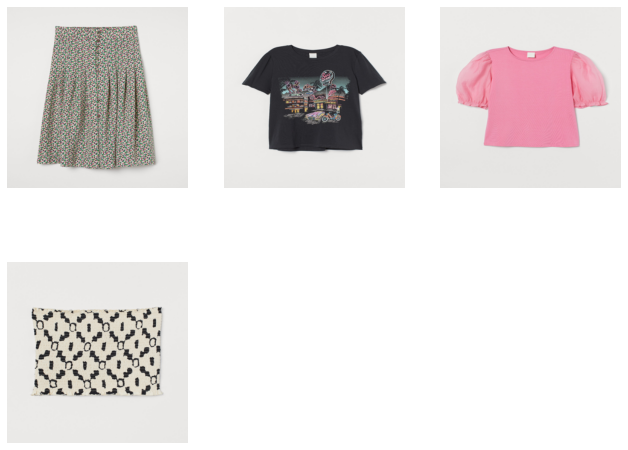

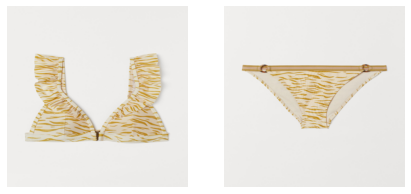

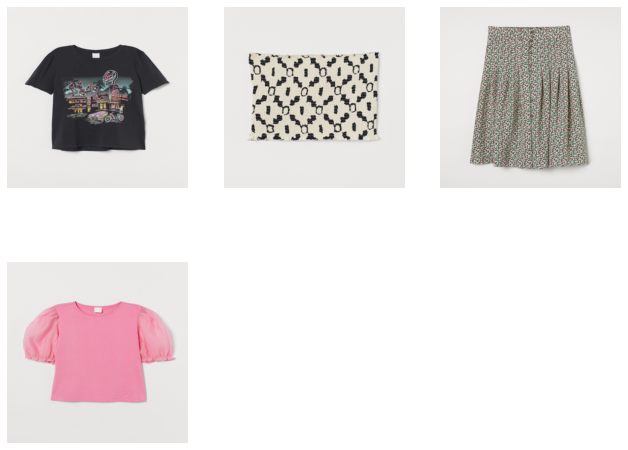

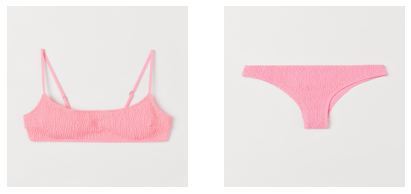

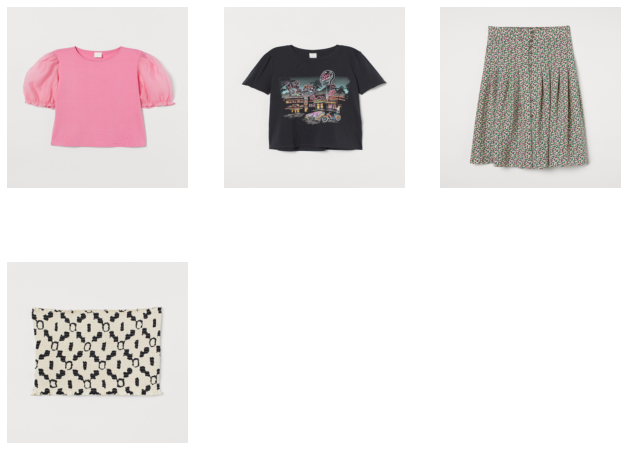

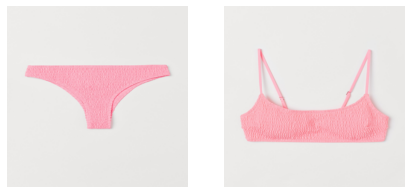

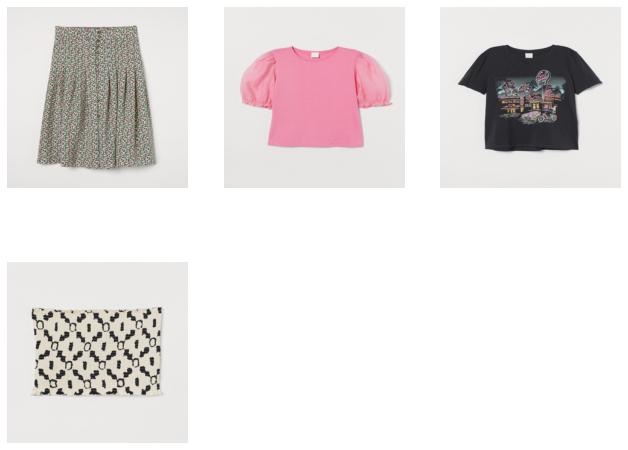

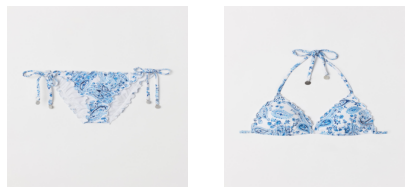

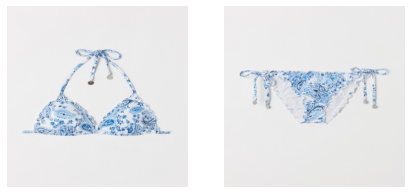

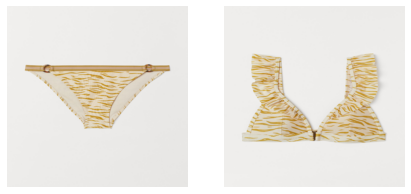

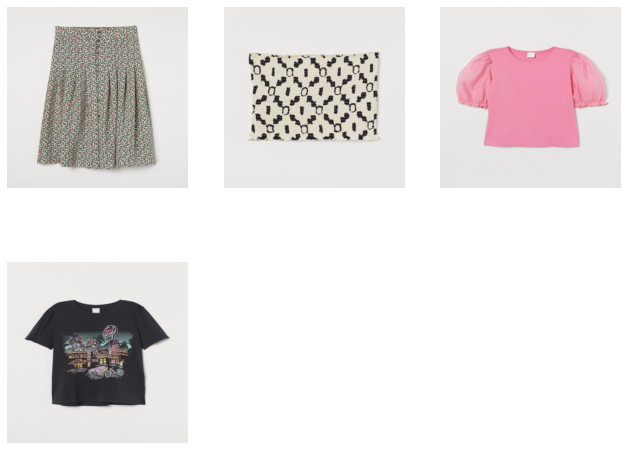

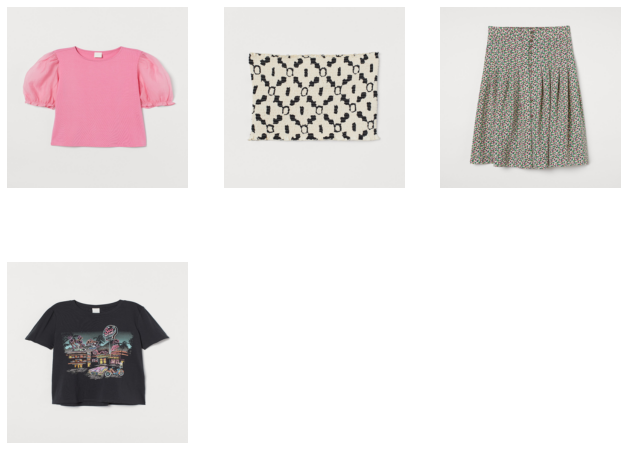

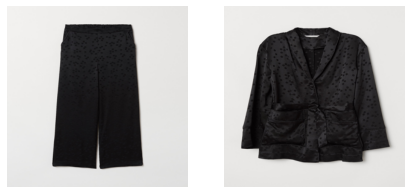

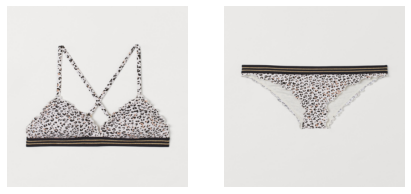

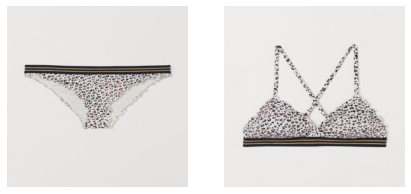

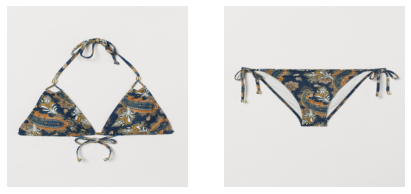

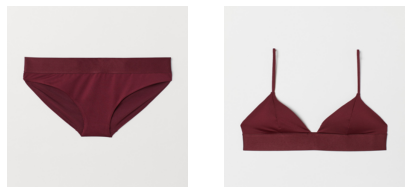

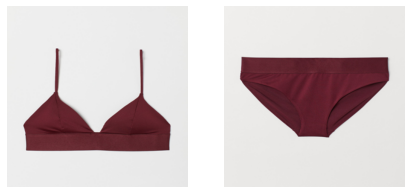

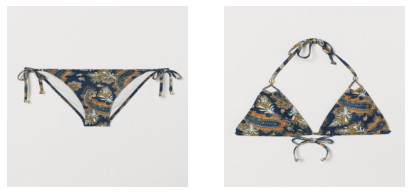

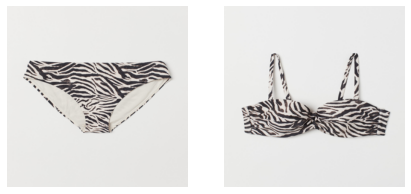

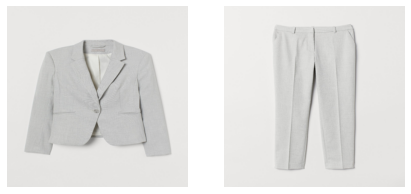

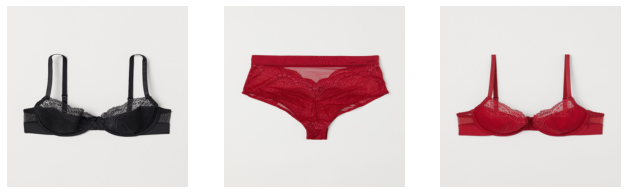

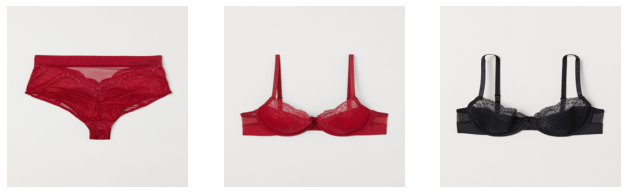

In [112]:
for index, row in df_apriori.iterrows():
    set_antecedent = row['Antecedent']
    set_consequent = row['Consequent']
    items = list(set_antecedent) + list(set_consequent)
    display_articles(items)

#### Analise do cliente

Clientes semelhantes pela compra

In [161]:
pivot.head()

customer_id,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37e011580a479e80aa94,000fb6e772c5d0023892065e659963da90b1866035558ec16fca51b0dcfb7e59,00201f34c8c92683263346d78c2b45ffd0c6927229542d8040a5c5c38b174eb6,0024dea548c64fb75a563e0b300c0b16210decee446f1aa9ed6dcf2cc965d462,00357b192b81fc83261a45be87f5f3d59112db7d117513c1e908e6a7021edc35,0036a44bd648ce2dbc32688a465b9628b7a78395302f26dd57b4ed75dce9b70c,003f1bdc9212bd81fd5ec35bf7285580103cd8a469340efed1d27f3b86d7f28f,0040e2fc2d1e7931a38355aca56b2c62b87e65051b72878c813c093d7b9b87aa,00459e5341c64d459a496c4cf5eb9016e2df3a34cbafaf3164aa7bd07a58f6f5,0045ff4aad72162bce75d1fe148a8bbe7b59263ef26d9a22dd047dfcc2880242,...,ffc66f427202c975f39e9127ddb597ccbfc818c474a779f66e5d0b1fb4f9c7c3,ffcf6925455b8aa0894f77e26a74f56b974e1a372f068c7dd8ab08f4641cb8c3,ffd4cf2217de4a0a3f9f610cdec334c803692a18af08ac55b4c6fb955cc836b1,ffd8e32e538255ececbef268d6f04ffcdf66fe00a1b459e197bb9b5f06fdfff1,ffe6376eb6b854d842e5a7714ea758de127f086a60d67d5cf425ef20361acea1,ffed71450acc902268fc4b99dfdc28f1a22583f573863b8639fe26671be9db40,fff2282977442e327b45d8c89afde25617d00124d0f99982410630ac51314356,fff3573d9131d15da6a46c1ca8f03b5d37e4f6b804171ea27278a18a2d8ca0c7,fffabaebcc10efa0e613b58de37901e04fa25a2f90a0a8cba67e3b9a57497ab5,fffe7116f9f68e8ad287fd7b6e33aad4871d7080e77d2d5e52636ba1c27cf032
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,2,0,0,0,0
108775044,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
110065001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110065002,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
110065011,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [162]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [163]:
sparse = csr_matrix(pivot)

In [164]:
model = NearestNeighbors(algorithm="brute")
model.fit(sparse)

NearestNeighbors(algorithm='brute')

In [165]:
distances, suggestions = model.kneighbors(pivot.iloc[0,:].values.reshape(1, -1))

In [166]:
for i in range(len(suggestions)):
    recom = pivot.index[suggestions[i]].values

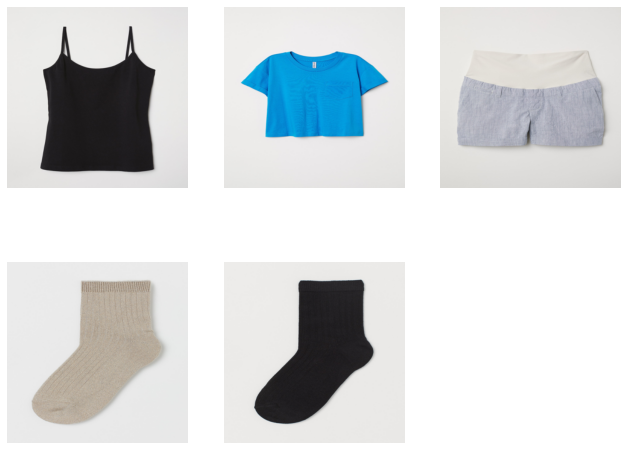

In [167]:
display_articles(recom)

#### Teste ...

In [31]:
t.head()

,t_dat,customer_id,article_id,price,sales_channel_id
84,2018-09-20,00609a1cc562140fa87a6de432bef9c9f0b936b259ad30...,611415005,0.016932,2
85,2018-09-20,00609a1cc562140fa87a6de432bef9c9f0b936b259ad30...,578374001,0.042356,2
86,2018-09-20,00609a1cc562140fa87a6de432bef9c9f0b936b259ad30...,673677002,0.016932,2
87,2018-09-20,00609a1cc562140fa87a6de432bef9c9f0b936b259ad30...,676352001,0.025407,2
88,2018-09-20,00609a1cc562140fa87a6de432bef9c9f0b936b259ad30...,611415001,0.016932,2


In [32]:
customer_id = '0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37e011580a479e80aa94'

In [33]:
z = t[t['customer_id'] == customer_id]

In [34]:
w = z.groupby('article_id')['customer_id'].count().reset_index()
w = w.rename(columns={"customer_id": "sales_count"})

In [35]:
h = z.merge(w, on='article_id')

In [36]:
h.drop(['customer_id', 'price', 'sales_channel_id'], axis=1, inplace=True)

In [37]:
h.drop_duplicates(['article_id'], inplace=True)
h.shape

(555, 3)

In [38]:
hs = h.sort_values(by=['t_dat', 'sales_count'], ascending=False)

In [39]:
articles_b = hs[:10]['article_id']

In [40]:
my = articles_nominal[articles_nominal['article_id'].isin(articles_b)].copy()

In [41]:
#Tratandom string
for i in my.columns[1:]:
    my[i] = my[i].str.lower().replace(" ","").replace("."," ").replace(","," ")

In [42]:
cols = ['prod_name', 'product_type_name', 'product_group_name',
       'graphical_appearance_name', 'colour_group_name',
       'perceived_colour_value_name', 'perceived_colour_master_name',
       'department_name', 'index_name', 'index_group_name', 'section_name',
       'garment_group_name', 'detail_desc']

In [43]:
my['combined'] = my[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')

my['combined'] = my['combined'].fillna('')

tfidf_matrix = tfidf.fit_transform(my['combined'])

In [45]:
df = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
df

,ankle,anna,basic,basics,bead,beige,beverly,black,blazer,blend,...,waist,washed,weave,white,wide,womens,wool,woven,zip,zipped
0,0.172734,0.000000,0.000000,0.000000,0.000000,0.000000,0.172734,0.000000,0.00000,0.000000,...,0.114216,0.172734,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.146839,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.254413,0.00000,0.000000,...,0.098945,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.127206,0.000000,0.149639
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.135695,...,0.000000,0.000000,0.00000,0.000000,0.174452,0.110166,0.152625,0.000000,0.000000,0.000000
3,0.000000,0.186399,0.000000,0.000000,0.186399,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.372798,0.000000,0.100064,0.138630,0.000000,0.158456,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.442493,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.118771,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.337053,0.168527,0.000000,0.000000,0.000000,0.000000,0.00000,0.111435,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.14306,0.000000,...,0.000000,0.000000,0.14306,0.000000,0.000000,0.076799,0.212796,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.137568,...,0.137568,0.000000,0.00000,0.000000,0.000000,0.111687,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.136431,...,0.136431,0.000000,0.00000,0.000000,0.000000,0.110764,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.295386,0.00000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.147693,0.000000,0.000000,0.147693,0.000000,0.000000


In [46]:
values = df.sum(axis = 0, skipna = True).sort_values(ascending=False)

In [47]:
des = values[values > 0.6].index.tolist()

In [48]:
description = ' '.join(str(e) for e in des)

In [49]:
description

'ladieswear divided jersey light sweatshirt fancy trousers elasticated garment body long knitwear soft collection fabric purple womens everyday'

#### Semelhança de produtos

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [26]:
articles_nominal.shape

(105542, 14)

Criação da coluna ```combined``` que possui a combinação de todas as características de um produto.

In [27]:
#Tratandom string
for i in articles_nominal.columns[1:]:
    articles_nominal[i] = articles_nominal[i].str.lower().replace(" ","").replace("."," ").replace(","," ")

In [70]:
cols = ['prod_name', 'product_type_name', 'product_group_name',
       'graphical_appearance_name', 'colour_group_name',
       'perceived_colour_value_name', 'perceived_colour_master_name',
       'department_name', 'index_name', 'index_group_name', 'section_name',
       'garment_group_name', 'detail_desc']

In [71]:
articles_nominal['combined'] = articles_nominal[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [72]:
articles_nominal.head()

,article_id,prod_name,product_group_name,product_type_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,combined
0,108775015,strap top,garment upper body,vest top,solid,black,dark,black,jersey basic,ladieswear,ladieswear,womens everyday basics,jersey basic,jersey top with narrow shoulder straps.,strap top vest top garment upper body solid bl...
1,108775044,strap top,garment upper body,vest top,solid,white,light,white,jersey basic,ladieswear,ladieswear,womens everyday basics,jersey basic,jersey top with narrow shoulder straps.,strap top vest top garment upper body solid wh...
2,108775051,strap top (1),garment upper body,vest top,stripe,off white,dusty light,white,jersey basic,ladieswear,ladieswear,womens everyday basics,jersey basic,jersey top with narrow shoulder straps.,strap top (1) vest top garment upper body stri...
3,110065001,op t-shirt (idro),underwear,bra,solid,black,dark,black,clean lingerie,lingeries/tights,ladieswear,womens lingerie,"under-, nightwear","microfibre t-shirt bra with underwired, moulde...",op t-shirt (idro) bra underwear solid black da...
4,110065002,op t-shirt (idro),underwear,bra,solid,white,light,white,clean lingerie,lingeries/tights,ladieswear,womens lingerie,"under-, nightwear","microfibre t-shirt bra with underwired, moulde...",op t-shirt (idro) bra underwear solid white li...


Divisão do dataframe ```articles_nominal``` em quatro dataframes com objetivo de criar o TfidfVectorizer de todos produtos, mas devido a quantidade não é possível fazer com todos os dados.

In [73]:
articles_nominal_part_1 = articles_nominal[0:26386].copy()
articles_nominal_part_2 = articles_nominal[26386:(26386 + 26121)].copy()
articles_nominal_part_3 = articles_nominal[(26386 + 26121):(26386 + 26121 + 26518)].copy()
articles_nominal_part_4 = articles_nominal[(26386 + 26121 + 26518):].copy()

In [74]:
print(f"Part_1: {articles_nominal_part_1.shape}")
print(f"Part_2: {articles_nominal_part_2.shape}")
print(f"Part_3: {articles_nominal_part_3.shape}")
print(f"Part_4: {articles_nominal_part_4.shape}")

print(f"Total: {articles_nominal_part_1.shape[0] + articles_nominal_part_2.shape[0] + articles_nominal_part_3.shape[0] + articles_nominal_part_4.shape[0]}")

Part_1: (26386, 15)
Part_2: (26121, 15)
Part_3: (26518, 15)
Part_4: (26517, 15)
Total: 105542


In [31]:
def create_TfidfVectorizer(df):
    tfidf = TfidfVectorizer(stop_words='english')
    
    df['combined'] = df['combined'].fillna('')

    tfidf_matrix = tfidf.fit_transform(df['combined'])

    tfidf_matrix.shape

    return tfidf_matrix

In [150]:
def get_recommendations(title, cosine_sim, indices, pos):
    try:
        x = [26386, 26121, 26518, 26517]
        idx = indices[title] - x[pos]

        sim_scores = list(enumerate(cosine_sim[idx]))

        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        sim_scores = sim_scores[:12]

        article_indices = [i[0] for i in sim_scores]

        return articles_nominal['article_id'].iloc[article_indices]
    except Exception as e:
        print("Error: ", e)
        return []

In [75]:
tfidf_matrix_part_1 = create_TfidfVectorizer(articles_nominal_part_1)
tfidf_matrix_part_2 = create_TfidfVectorizer(articles_nominal_part_2)
tfidf_matrix_part_3 = create_TfidfVectorizer(articles_nominal_part_3)
tfidf_matrix_part_4 = create_TfidfVectorizer(articles_nominal_part_4)

In [34]:
articles_nominal_array = [articles_nominal_part_1, articles_nominal_part_2, articles_nominal_part_3, articles_nominal_part_4]

In [76]:
cosine_sim_part_1 = cosine_similarity(tfidf_matrix_part_1, tfidf_matrix_part_1)

In [77]:
cosine_sim_part_2 = cosine_similarity(tfidf_matrix_part_2, tfidf_matrix_part_2)

In [78]:
cosine_sim_part_3 = cosine_similarity(tfidf_matrix_part_3, tfidf_matrix_part_3)

MemoryError: Unable to allocate 5.24 GiB for an array with shape (26518, 26518) and data type float64

In [38]:
cosine_sim_part_4 = cosine_similarity(tfidf_matrix_part_4, tfidf_matrix_part_4)

In [151]:
articles_nominal_part_3[50:55]

,article_id,prod_name,product_group_name,product_type_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,combined
52557,701548001,nina holiday ll pj (w),nightwear,pyjama set,check,red,medium,red,nightwear,lingeries/tights,ladieswear,"womens nightwear, socks & tigh","under-, nightwear",pyjamas in a soft cotton flannel. long-sleeved...,nina holiday ll pj (w) pyjama set nightwear ch...
52558,701555001,logg jacob,garment upper body,blouse,solid,white,light,white,woven top,ladieswear,ladieswear,h&m+,blouses,blouse in an airy cotton weave with broderie a...,logg jacob blouse garment upper body solid whi...
52559,701561001,bobby cut out boot,shoes,boots,solid,black,dark,black,boots,ladies accessories,ladieswear,womens shoes,shoes,"ankle boots in imitation leather with studs, o...",bobby cut out boot boots shoes solid black dar...
52560,701561002,bobby cut out boot,shoes,boots,solid,beige,dusty light,mole,boots,ladies accessories,ladieswear,womens shoes,shoes,"ankle boots in imitation leather with studs, o...",bobby cut out boot boots shoes solid beige dus...
52561,701568001,sb conner pile rain parka,garment upper body,jacket,solid,dark green,medium,green,kids boy outdoor,children sizes 92-140,baby/children,kids outerwear,outdoor,rain jacket in wind- and water-repellent funct...,sb conner pile rain parka jacket garment upper...


In [39]:
cosine_sim_array = [cosine_sim_part_1, cosine_sim_part_2, cosine_sim_part_3, cosine_sim_part_4]

In [59]:
def find_dataframe(item):
    item_df = 1
    aux = articles_nominal_part_1.loc[articles_nominal_part_1['article_id'] == item]
    if aux.empty:
        aux = articles_nominal_part_2.loc[articles_nominal_part_2['article_id'] == item]
        if aux.empty:
            aux = articles_nominal_part_3.loc[articles_nominal_part_3['article_id'] == item]
            if aux.empty:
                aux = articles_nominal_part_4.loc[articles_nominal_part_4['article_id'] == item]
                if aux.empty:
                    item_df = -1
                else:
                    item_df = 4
            else:
                item_df = 3
        else:
            item_df = 2

    return item_df

In [142]:
def get_recom(item, cossine_sim, df, pos):
    indices = pd.Series(df.index, index=df['article_id']).drop_duplicates()
    recom = get_recommendations(item, cossine_sim, indices, pos)
    return list(recom)

In [155]:
item = 701561002
item_df = find_dataframe(item)
cosine_sim = cosine_sim_array[item_df-1]
tfidf_matrix = articles_nominal_array[item_df-1]
recom = get_recom(item, cosine_sim, tfidf_matrix, item_df)
display_articles(recom)

#### Clientes

Clientes que fizeram somente 1 compra

    - Analisar se esse item está no apriori
    - Buscar semenlhantes pela compra
    - Buscar semelhantes pela descrição
    - Recomendar top 12

In [383]:
customers.shape

(1371980, 7)

In [381]:
counts = transactions['customer_id'].value_counts()

In [384]:
counts

be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b    1895
b4db5e5259234574edfff958e170fe3a5e13b6f146752ca066abca3c156acc71    1441
49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05b50a4cd88e34d0748f    1364
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc    1361
cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed6012e7e5bea016b4d6    1237
                                                                    ... 
63b70b71291668f0a63ade8e321fb3eccb80eba164f2087dad471de065f18e1f       1
950b172c36d169bf427545991fe66371f21a085799b44780fdcb2da6a3091613       1
7c284f13f4af9d6a53f97279381638ed0cb7afaa4fd4f3eaadc21993ea45fc69       1
62d49d0ae11a4f65fa31e354cb87f6b557ebec648e0e5e71435d2dd190d1ccc4       1
268eaa31a07d6f2f4f060bfcf32a660f3ea3dbb21ef14cd09fc2545f4e0b5c10       1
Name: customer_id, Length: 1362281, dtype: int64

In [406]:
r = (counts > 1) & (counts <= 10)
r_index = r[r].index
df_t = transactions[transactions['customer_id'].isin(r_index)].copy()

In [398]:
df_t

,t_dat,customer_id,article_id,price,sales_channel_id
49,2018-09-20,0021da829b898f82269fc51feded4eac2129058ee95bd7...,649356002,0.027441,1
50,2018-09-20,0021da829b898f82269fc51feded4eac2129058ee95bd7...,579941002,0.019814,1
51,2018-09-20,0021da829b898f82269fc51feded4eac2129058ee95bd7...,629760002,0.015237,1
52,2018-09-20,0021da829b898f82269fc51feded4eac2129058ee95bd7...,625229004,0.019814,1
72,2018-09-20,00402f4463c8dc1b3ee54abfdea280e96cd87320449eca...,507909001,0.025407,1
...,...,...,...,...,...
31788290,2020-09-22,ff813df6887c2a6d7065aed247bf1db3d6f629eee23798...,806388002,0.013542,1
31788301,2020-09-22,ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1df...,895730002,0.045746,2
31788302,2020-09-22,ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1df...,740519002,0.045746,2
31788308,2020-09-22,ffcd5ff3fd5b9ee6b984c143c973fd2697ca141483d381...,918522001,0.042356,2


In [418]:
number_sales = df_t.groupby(['customer_id', 'article_id'])['customer_id'].count()

In [419]:

#number_sales = number_sales.rename(columns={"customer_id": "sales_count"})
fn = df_t.merge(number_sales, on='article_id')

In [400]:
temp = fn.sort_values(by=['t_dat', 'sales_count'], ascending=False)

In [401]:
temp

,t_dat,customer_id,article_id,price,sales_channel_id,sales_count
991143,2020-09-22,019e5eb5399e8488b901fc3edcbfeb3d004855a0da3db3...,706016001,0.033881,2,5231
991144,2020-09-22,057023bdf60896e1c37ff32c05577dfdc7a86cb0f17605...,706016001,0.033881,2,5231
991145,2020-09-22,09f3f5723d8f782a4167afacb46f7c21b4d09ba344e28f...,706016001,0.030492,1,5231
991146,2020-09-22,1c959573dbbd4cc524796644dbdd6ee351368bb517450a...,706016001,0.033881,2,5231
991147,2020-09-22,2345ca1c01627305e15afbabba28d99f525e6fe140db05...,706016001,0.033881,2,5231
...,...,...,...,...,...,...
353610,2018-09-20,f3380b1c54cb421543432502c47cad7b58ea1e0805443f...,595078001,0.016932,2,1
355078,2018-09-20,f5ec8589258f4eb9ea9b1d467f1e027eb41c30e46ac892...,482638018,0.007288,2,1
355863,2018-09-20,f77ae7fc91b0063cd523070f673f6ceacd07c20f3842fc...,576821002,0.011847,2,1
357252,2018-09-20,f84fbe53248fc80802bd51e940e22b7c08ed0962443784...,593494002,0.018627,2,1


In [374]:
print(fn["customer_id"].unique())

['0021da829b898f82269fc51feded4eac2129058ee95bd75bb1591e2eb14ecc79'
 '2aa27310d13daa3112d5ccfd6f32de0222546657752fda2530e3230e801cb83e'
 'fc13db5277acfb2fd53fe1d952bbff3af6815ef68043d50a23a01e70d47da1fa' ...
 '12229caace24adeb007ade52a8c646483965a9f7bd10fc8469e9db9dbc053e3e'
 '703be2d1c8f589434f994844b89acc00b0861a6228e43dcb9b89bc11cbfdec57'
 '8d1533313b2ddde5407737c375e80e90dfd3f49457cfe0cff97fa0b0ac4171c6']


In [365]:
df_t.drop(['price', 'sales_channel_id', 't_dat'], axis=1, inplace=True)

In [366]:
df_t.shape

(31656810, 2)

In [186]:
z = transactions['customer_id'].value_counts() == 1

In [188]:
z.astype('boolean')

be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b    False
b4db5e5259234574edfff958e170fe3a5e13b6f146752ca066abca3c156acc71    False
49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05b50a4cd88e34d0748f    False
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc    False
cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed6012e7e5bea016b4d6    False
                                                                    ...  
63b70b71291668f0a63ade8e321fb3eccb80eba164f2087dad471de065f18e1f     True
950b172c36d169bf427545991fe66371f21a085799b44780fdcb2da6a3091613     True
7c284f13f4af9d6a53f97279381638ed0cb7afaa4fd4f3eaadc21993ea45fc69     True
62d49d0ae11a4f65fa31e354cb87f6b557ebec648e0e5e71435d2dd190d1ccc4     True
268eaa31a07d6f2f4f060bfcf32a660f3ea3dbb21ef14cd09fc2545f4e0b5c10     True
Name: customer_id, Length: 1362281, dtype: boolean

In [193]:
z_index = z[z].index
df_t = transactions[transactions['customer_id'].isin(z_index)].copy()

In [194]:
df_t.drop(['price', 'sales_channel_id', 't_dat'], axis=1, inplace=True)

In [195]:
df_t

,customer_id,article_id
96,0077ba345ef6aa8781802107df25bbb8a14fdcd04130c3...,534795002
221,013cc00a6fe53e361d8b5da4153c5b8907c09bf951dd4e...,590748001
247,015d779989111f5158d089a639b42390cd864f2001b1ed...,626054001
299,01b0efc42c236759c44edb9b3c97c9f213d581ce647cf8...,615508001
539,02b4b6f6e43c3eccd8b8889330654519ac3c55e5fc2ec3...,672890004
...,...,...
31787825,fbadb1b2d3f38a1cd24965237ef31e1c243d9419a6ec7a...,806241009
31787875,fc192220bf89e9c1853260e28735efb17e8efe9e9a6dd8...,804992013
31787881,fc41b514ebf109933d76e7fd70fe765ba6f8f142669ca0...,901811001
31788104,fdd8277a1a3f77b8c74a9a4f53e567d621f606948e2071...,865938003


In [197]:
df_t.drop_duplicates(['customer_id', 'article_id'], inplace=True)
df_t.shape

(131514, 2)

In [258]:
def find_items_apriori(article_id):
    items_recom = []
    for index, row in df_apriori.iterrows():
        set_antecedent = row['Antecedent']
        set_consequent = row['Consequent']
        if set_antecedent == { article_id }:
            items_recom = items_recom + list(set_consequent)
    return items_recom

In [260]:
pivot.head()

customer_id,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37e011580a479e80aa94,000fb6e772c5d0023892065e659963da90b1866035558ec16fca51b0dcfb7e59,00201f34c8c92683263346d78c2b45ffd0c6927229542d8040a5c5c38b174eb6,0024dea548c64fb75a563e0b300c0b16210decee446f1aa9ed6dcf2cc965d462,00357b192b81fc83261a45be87f5f3d59112db7d117513c1e908e6a7021edc35,0036a44bd648ce2dbc32688a465b9628b7a78395302f26dd57b4ed75dce9b70c,003f1bdc9212bd81fd5ec35bf7285580103cd8a469340efed1d27f3b86d7f28f,0040e2fc2d1e7931a38355aca56b2c62b87e65051b72878c813c093d7b9b87aa,00459e5341c64d459a496c4cf5eb9016e2df3a34cbafaf3164aa7bd07a58f6f5,0045ff4aad72162bce75d1fe148a8bbe7b59263ef26d9a22dd047dfcc2880242,...,ffc66f427202c975f39e9127ddb597ccbfc818c474a779f66e5d0b1fb4f9c7c3,ffcf6925455b8aa0894f77e26a74f56b974e1a372f068c7dd8ab08f4641cb8c3,ffd4cf2217de4a0a3f9f610cdec334c803692a18af08ac55b4c6fb955cc836b1,ffd8e32e538255ececbef268d6f04ffcdf66fe00a1b459e197bb9b5f06fdfff1,ffe6376eb6b854d842e5a7714ea758de127f086a60d67d5cf425ef20361acea1,ffed71450acc902268fc4b99dfdc28f1a22583f573863b8639fe26671be9db40,fff2282977442e327b45d8c89afde25617d00124d0f99982410630ac51314356,fff3573d9131d15da6a46c1ca8f03b5d37e4f6b804171ea27278a18a2d8ca0c7,fffabaebcc10efa0e613b58de37901e04fa25a2f90a0a8cba67e3b9a57497ab5,fffe7116f9f68e8ad287fd7b6e33aad4871d7080e77d2d5e52636ba1c27cf032
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,2,0,0,0,0
108775044,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
110065001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
110065002,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
110065011,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [287]:
def find_items_simmilary_by_customers(article_id):
    try:
        x = pivot.loc[article_id]
        distances, suggestions = model.kneighbors(x)
        recom = []
        for i in range(len(suggestions)):
            recom = pivot.index[suggestions[i]].values
        return recom
    except:
        return []


In [301]:
def find_items_simmilary_by_article(article_id):
    return list(get_recommendations(article_id, cosine_sim))

In [358]:
sub  = []
for index, row in df_t.iterrows():
    recom = []
    customer_id = row['customer_id']
    article_id = row['article_id']
    recom = find_items_apriori(article_id) #apriori
    recom = find_items_simmilary_by_customers(article_id)
    recom = find_items_simmilary_by_article(article_id)
    if len(recom) > 0:
        recom = recom + top_12_products_last_week
    else: 
        recom = top_12_products_last_week
    recom_str = np.array_str(recom).replace('[', '').replace(']', '')
    data = [customer_id, recom_str]
    sub.append(data)


In [359]:
sub_df = pd.DataFrame(sub, columns=['customer_id', 'prediction'])

In [360]:
sub_df

,customer_id,prediction
0,0077ba345ef6aa8781802107df25bbb8a14fdcd04130c3...,1454068004 1516105012 1438425004 1456963007 14...
1,013cc00a6fe53e361d8b5da4153c5b8907c09bf951dd4e...,1510021003 1461788005 1466972004 1427095003 15...
2,015d779989111f5158d089a639b42390cd864f2001b1ed...,1545327003 1549771003 1550152002 1457240005 15...
3,01b0efc42c236759c44edb9b3c97c9f213d581ce647cf8...,1534781003 1539751005 1466159003 1505058011 15...
4,02b4b6f6e43c3eccd8b8889330654519ac3c55e5fc2ec3...,919273002 924243002 924243001 889550002 923340...
...,...,...
131509,fbadb1b2d3f38a1cd24965237ef31e1c243d9419a6ec7a...,919273002 924243002 924243001 889550002 923340...
131510,fc192220bf89e9c1853260e28735efb17e8efe9e9a6dd8...,919273002 924243002 924243001 889550002 923340...
131511,fc41b514ebf109933d76e7fd70fe765ba6f8f142669ca0...,919273002 924243002 924243001 889550002 923340...
131512,fdd8277a1a3f77b8c74a9a4f53e567d621f606948e2071...,919273002 924243002 924243001 889550002 923340...


In [361]:
sub_df.to_csv('sample_submission.csv', encoding='utf-8', index=False)